<a href="https://colab.research.google.com/github/youngchul-sung/deep-learning-with-python/blob/master/6_3_advanced_usage_of_recurrent_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I didn't include execution results here because it takes too much time to train models.

In [1]:
%tensorflow_version 2.x

from tensorflow import keras
keras.__version__

TensorFlow 2.x selected.


'2.2.4-tf'

In [0]:
import os

if not os.path.exists('deep-learning-with-python-notebooks'):
    !git clone https://github.com/rickiepark/deep-learning-with-python-notebooks.git

In [3]:
data_dir = 'deep-learning-with-python-notebooks/datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [0]:
from matplotlib import pyplot as plt

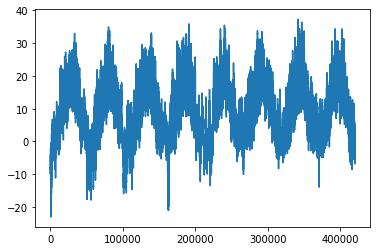

In [6]:
temp = float_data[:, 1]  # 온도(섭씨)
plt.plot(range(len(temp)), temp)
plt.show()

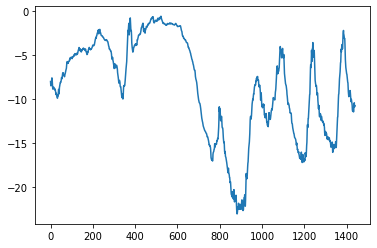

In [7]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [12]:
0.29 * std[1]

2.5672247338393395

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3360)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                107552    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 12s 23ms/step - loss: 1.5072 - val_loss: 0.7113
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.5008 - val_loss: 0.4134
Epoch 

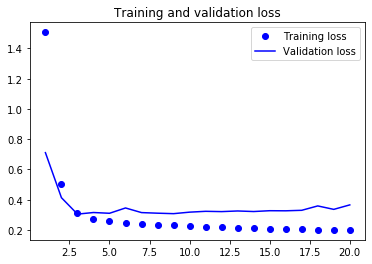

In [14]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
#@title
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3015 - val_loss: 0.2741
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2834 - val_loss: 0.2670
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2792 - val_loss: 0.2656
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2729 - val_loss: 0.2681
Epoch 5/20
5

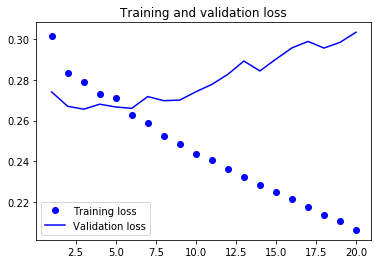

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 263s 527ms/step - loss: 0.3379 - val_loss: 0.2782
Epoch 2/40
500/500 [==============================] - 259s 518ms/step - loss: 0.3111 - val_loss: 0.2707
Epoch 3/40
500/500 [==============================] - 260s 520ms/step - loss: 0.3057 - val_loss: 0.2735
Epoch 4/40
500/500 [==============================] - 265s 530ms/step - loss: 0.2986 - val_loss: 0.2671
Epoc

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5)
                    ))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [0]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [0]:
from tensorflow.keras import backend as K
K.clear_session()

In [0]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)